# Regression, Correlation, and Modeling
In this lab, we'll explore how regression and correlation look in higher frequency ranges compared with raw signals.

The value in extracting different neural features is that they often have more favorable properties. For example, perhaps we can find a neural signal that is more spatially-localized, or has a better signal-to-noise ratio. Much of research in cognitive neuroscience aims at finding such signals.

We'll finish by using regression to relate patterns of activity to different kinds of stimuli. Regression is a powerful tool for using external events or stimulus values to predict patterns of brain activity, something we'll focus on in the second half of the class.

In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import datascience as ds
import neurods as nds
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

# *** Don't forget to use `%matplotlib inline` when you create non-interactive plots! ***
%matplotlib inline

# The data and task
For this lab you'll be using the same ECoG dataset that we've used before. However, we'll look at a different component of the ECoG signal (high-frequency activity). We'll look at this signal's relationship to GFP. Finally, we'll use regression to tease apart which channels are responding to one trial type over another. This will tell us which channels respond most strongly to "consonant" vs. "dissonant" sounds.

First, we'll load the same ECoG dataset we've used before, along with sensor positions and a picture of the brain.

In [4]:
path_ecog = nds.io.data_list['ecog'] + 'chords_task/'
raw = mne.io.Raw(path_ecog + 'ecog_resamp-raw.fif', preload=True)
time = ds.Table.read_table(path_ecog + 'meta_time.csv', index_col=0)
meta_elecs = ds.Table.read_table(path_ecog + 'meta_chans.csv')
meta_elecs = meta_elecs.where('use', 1)
im = plt.imread(path_ecog + 'brain.png')



Opening raw data file /home/shared/cogneuro-connector/data/ecog/chords_task/ecog_resamp-raw.fif...
Isotrak not found
    Range : 0 ... 219521 =      0.000 ...   439.042 secs
Ready.
Reading 0 ... 219521  =      0.000 ...   439.042 secs...


* Drop any channels marked as "bad" in `meta_elecs` so that we don't bias results...

In [7]:
### STUDENT ANSWER
raw.drop_channels(meta_elecs.where('bad', 1)['ch_name'])

<Raw  |  ecog_resamp-raw.fif, n_channels x n_times : 61 x 219522 (439.0 sec), ~102.3 MB, data loaded>

One metric for signal-to-noise is the extent to which each electrode is correlated with all the other electrodes. If there are large amounts of correlation, it means that you have less information present in the data. 

> Think of it this way - if I have 3 signals and they're correlated, then knowing something about the first signal tells me a lot about the other two. This means that any information present in the first signal (e.g., did I just play sound A or sound B) will likely also be present in the other two. This means that the *total* amount of information in the 3 signals is relatively lower than if they were not correlated. If they are *not* correlated, then each signal is independent of the other, and they can store potentially different kinds of information.

* Calculate the correlation matrix for all channels in the raw data
* Plot it using `imshow`. What pattern do you see?

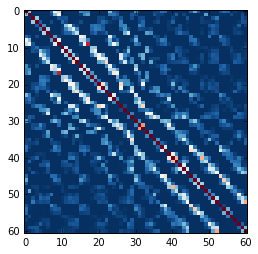

In [9]:
### STUDENT ANSWER

# Now, calculate the correlation matrix for all channels
corr = np.corrcoef(raw._data)

# Plot the correlation matrix with a vmin of 0, and a vmax of .5
f, ax = plt.subplots()
ax.imshow(corr, vmin=0, vmax=.7, cmap=plt.cm.RdBu_r, interpolation='nearest')

### LONG ANSWER
# Basically there should be diagonal lines below, similar to what we've seen before.

As you can see, there's a similar spatial pattern of correlation as we saw with EEG signals. However, as we have seen last week one of the benefits of using ECoG is that it contains activity in *higher frequencies*. Let's take a look at these higher frequencies in the context of spatial correlations.

* Extract the amplitude for a range of frequencies (using `tfr.extract_amplitude`)
  * Use 5 frequencies linearly spaced from 70 to 150 Hz (and then averaged together).

In [5]:
### STUDENT ANSWER

freqs = np.linspace(70, 150, 5)

# Extract the amplitude of each, then average them all together
raw_amp = nds.tfr.extract_amplitude(raw, freqs)

100%|██████████| 5/5 [00:26<00:00,  5.35s/it]


* Plot the this dataset with the `.plot` method.
* Note whether there seem to be large correlations between channels. How does this related to the raw (non high-frequency) data?

In [10]:
### STUDENT ANSWER

# Re-plot the data to see what this looks like
_ = raw_amp.plot(scalings='auto')

NameError: name 'raw_amp' is not defined

* What do you notice about the signal above? When one channel increases, do the others also increase?
* How is it different from raw data?
* Does it seem noisier or cleaner?

Next, we'll take a look at the correlation matrix for this high-frequency signal.

* Calculate the correlation matrix for the `Raw` data you've extracted.
* use `imshow` to plot the results. Use the same color limits that you plotted above (with the `vmin` and `vmax` parameters)

<IPython.core.display.Javascript object>


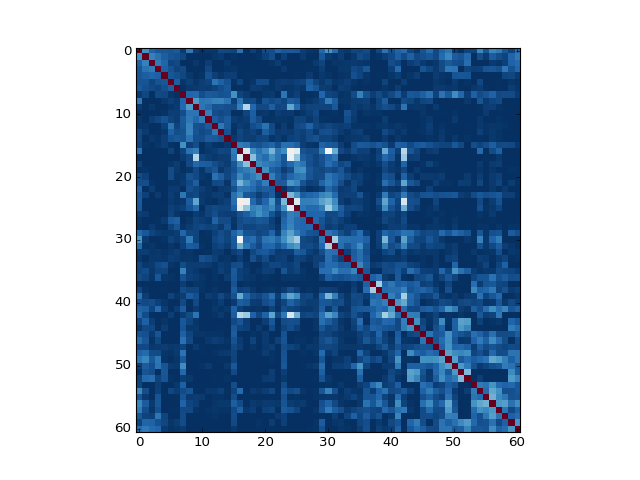

In [7]:
### STUDENT ANSWER

# Now, calculate the correlation matrix for all channels
corr = np.corrcoef(raw_amp._data)

# Plot the correlation matrix with a vmin of 0, and a vmax of .5
f, ax = plt.subplots()
ax.imshow(corr, vmin=0, vmax=.7, cmap=plt.cm.RdBu_r, interpolation='nearest')

* How does this compare with the correlation matrix for the raw data?
* What does this say about these high-frequency signals?
* What does this mean for our ability to use these signals to answer questions?

In [11]:
### STUDENT ANSWER
# In this case, the correlation matrix should be much less structured.
# This is because there are less correlations between these signals, and
# thus that the signals might have more information about the outside world.

# Event-related activity and regression
Next, we'll take a look at the event-related activity for this data.

* Using the "meta time" information, create an MNE events array. Only use the "consonants" events.
* Then, turn the `Raw` data into an `Epochs` object with these events
* Finally, plot the average event-related response once again

In [12]:
### STUDENT ANSWER
tmin, tmax = -.5, .5
ix_onsets = time['start'] * raw.info['sfreq']
ix_onsets = np.round(ix_onsets).astype(int)
ix_types = np.where(time['type'] == 'consonant', 1, 2)
events = np.vstack([ix_onsets, np.ones_like(ix_onsets), ix_types]).T
epochs = mne.Epochs(raw_amp, events, tmin=tmin, tmax=tmax, preload=True)

# Plot the average values again
_ = epochs.average().plot()

NameError: name 'raw_amp' is not defined

* What difference do you see in this plot compared with the raw epochs?
* Is it cleaner or noisier?

In [13]:
### STUDENT ANSWER
# This should be cleaner than the raw epochs.

We'll investigate how the high-frequency activity is distributed across ECoG channels by calculating the global field power using these signals.

* Calculate the GFP of the high-frequency amplitude that you calculated above
* Plot the average GFP over time.
* How does this signal compare to the one calculated from raw data?

In [14]:
### STUDENT ANSWER

ep_2 = epochs._data.mean(0) ** 2
gfp = ep_2.mean(0)

f, ax = plt.subplots()
ax.plot(epochs.times, gfp)

NameError: name 'epochs' is not defined

* Now, fit a regression model that predicts the GFP from the high-frequency amplitude of each electrode.
  * Don't forget to scale the electrode data before fitting!
  * Use the `LinearRegression` estimator in scikit-learn

In [12]:
### STUDENT ANSWER

# Now, fit a regression model to predict the GFP from the amplitude of each channel
# Don't forget to scale the channel values
X = scale(ep_2.T)
mod = LinearRegression(fit_intercept=False)
mod.fit(X, gfp)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

* Finally, plot the coefficients as a line plot

<IPython.core.display.Javascript object>


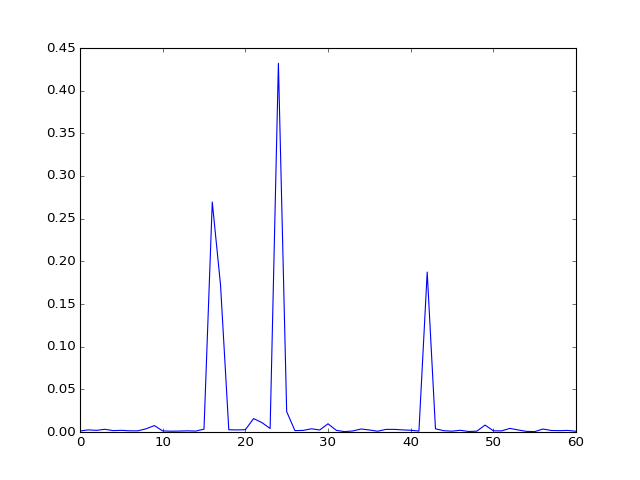

In [13]:
### STUDENT ANSWER

# Now plot the coefficients in a line:
f, ax = plt.subplots()
ax.plot(mod.coef_)

* How does this plot compare with the plot using raw data?
  * Why do you think this is?

* Is the scale of these coefficients different from the ones above?
  * Why do you think this is?


* Finally, plot the coefficients on the brain.

<IPython.core.display.Javascript object>


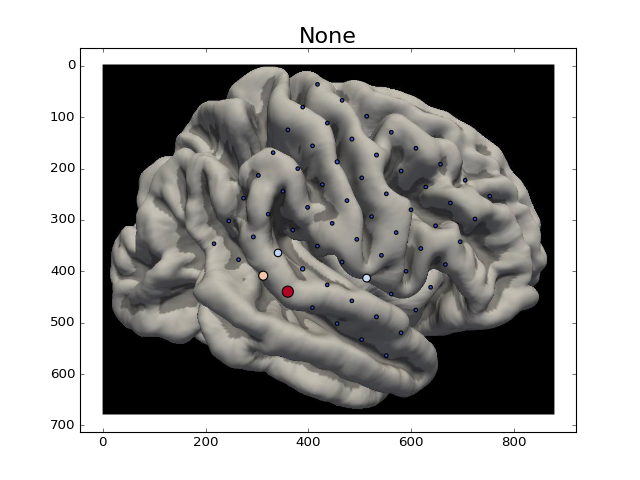

In [14]:
### STUDENT ANSWER

nds.viz.plot_activity_on_brain(meta_elecs['x'], meta_elecs['y'],
                               mod.coef_, im)

* Compare this with the model coefficients we plotted in lecture
  * How overlapping are these two plots?
  * Why would there be differences between them?

In [15]:
### STUDENT ANSWER

# Regression with external stimuli
Finally, we'll relate these neural signals to activity in the world. When we use a pattern of stimulus activity as inputs to a regression model that predicts brain activity as an output, it's called an *encoding model*. We'll see if the type of sound played results in different types of brain activity.

If you'll recall, this subject listened to "consonant" and "dissonant" chords. There was also occasionally the sound of a cat meowing. That gives us 3 types of auditory stimuli. Let's see if we can use these values to predict different amounts of neural activation.

* First, convert the event timings into an MNE "events" array. Make sure you include times for consonants, dissonants, and meows.
* Create a dictionary that maps event type names onto integers
* Then construct an MNE Epochs object from the high-frequency amplitude we used above.

In [15]:
tmin, tmax = -.5, .5

### STUDENT ANSWER
ix_onsets = time['start'] * raw.info['sfreq']
ix_onsets = np.round(ix_onsets).astype(int)
event_dict = dict(consonant=1, dissonant=2, meow=3)
ix_types = [event_dict[ii] for ii in time['type']]
events = np.vstack([ix_onsets, np.ones_like(ix_onsets), ix_types]).T
epochs = mne.Epochs(raw_amp, events, event_id=event_dict, tmin=tmin, tmax=tmax, preload=True)

The events passed to the Epochs constructor are not chronologically ordered.
105 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 105 events and 501 original time points ...
0 bad epochs dropped


* Plot the average activity for each event type (you should create 3 different plots)

<IPython.core.display.Javascript object>


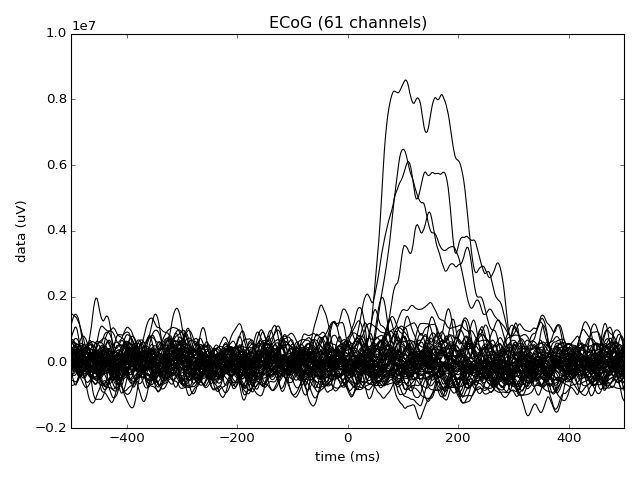

<IPython.core.display.Javascript object>


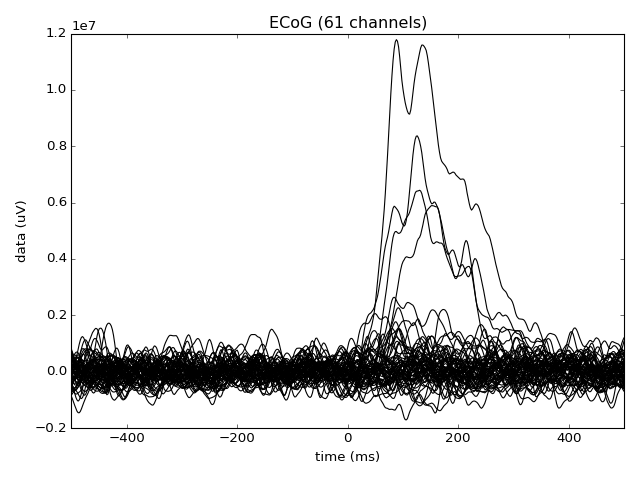

<IPython.core.display.Javascript object>


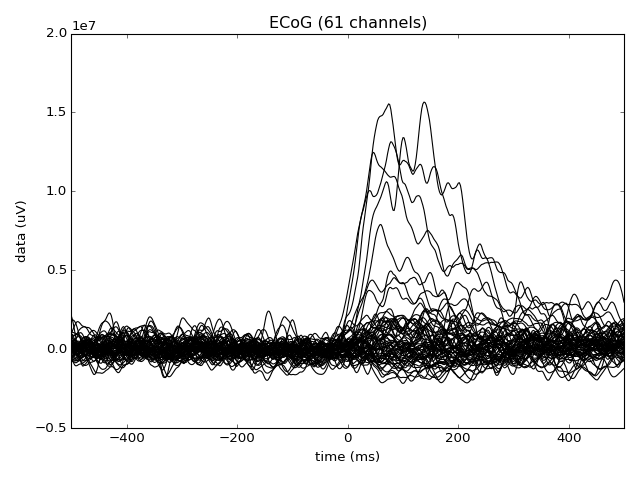

In [17]:
### STUDENT ANSWER

_ = epochs['consonant'].average().plot()

_ = epochs['dissonant'].average().plot()

_ = epochs['meow'].average().plot()

In the regression, we'll just use a single summary statistic of each trial instead of the fully time-varying neural signals.

* Calculate the mean amplitude of the ecog data from 0 seconds to 3 seconds. Do this for each trial. The output should be shape (n_trials, n_channels)
  * This will be the output of the regression model.
  * Call the variable "y".

In [19]:
### STUDENT ANSWER

mean_activity = epochs.copy().crop(0, .3)._data.mean(-1)
y = mean_activity

We want to know if stimulus type predicts evoked high-frequency activity. To use this in regression, we'll use *binary variables* to code for each type of stimulus. This is a matrix with 3 columns, one column per stimulus type. For each row, a `1` in a column means that the feature for that column was played. Each row will be a trial, so we can use this to code the stimulus type for every trial.

* Construct a numpy array of zeros of shape (n_trials, 3). We choose 3 because there are 3 stimulus types. Call it `X`.
* Iterate through each trial, and determine the stimulus that was played for that trial. Insert a `1` into the row/column of `X` according to that stimulus type.
  * The final result will be an array of shape `(n_trials, 3)`, where each row has two 0s and a single 1, encoding which stimulus type was played for that trial.

In [16]:
### STUDENT ANSWER

X = np.zeros([len(epochs), 3])
for ii, itype in enumerate(epochs.events[:, -1]):
    X[ii, itype-1] = 1

NameError: name 'epochs' is not defined

Now we have all the makings for a regression model. We have a collection of inputs (X) and a collection of outputs (y), we have several instances of each.

* Use the `LinearRegression` sklearn estimator to fit a model that predicts y from X.
  * Do *not* scale X this time. It is a binary variable of 0s and 1s, so scaling it doesn't make any sense and will mess up the regression.

> Note - you can fit multiple output variables at once by passing `y` as a matrix instead of a 1-D vector. `y` is expected to be shape `(n_samples, n_outputs)` (sklearn calls them `n_targets` instead of `n_outputs`). So in our case, we are fitting `n_channels` number of models. We'll get a set of coefficients for each

In [21]:
from sklearn.linear_model import LinearRegression

### STUDENT ANSWER

mod = LinearRegression()
mod.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Fitting the model creates a set of coefficients for each output you've included in `y`. It describes how the three stimulus types relate to the activity of `y`. Lower values mean that the presence of that stimulus type will result in less activity for that channel. Higher values mean the presence of that stimulus type increases the activity for that channel.

* Visualize the coefficients for all of our models simultaneously with `imshow`. The model coefficients will be stored as an attribute `.coef_`.

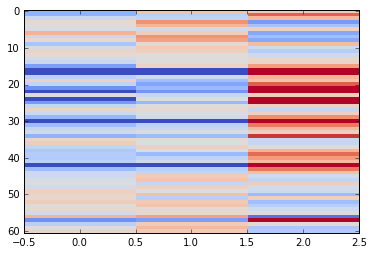

In [22]:
### STUDENT ANSWER

fig, axs = plt.subplots()
axs.imshow(mod.coef_, aspect='auto', interpolation='nearest',
           vmin=-1, vmax=1, cmap='coolwarm')

* What do you notice about the coefficients above? Do you see any patterns?
* Does one stimulus type seem to result in more activity than others? If so, why?

In [17]:
### STUDENT ANSWER

Finally, let's plot the "preferred" stimulus for each electrode on the brain.

* For each electrode, find the stimulus type with the biggest coefficient. Code this as a vector of length `n_channels` with integers representing the stimulus type. Look into the `argmax` function to do this quickly.
* Plot the results on the brain.

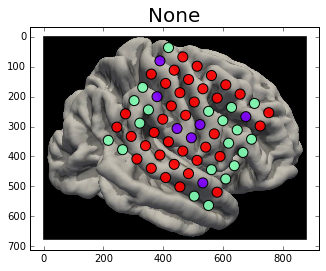

In [23]:
### STUDENT ANSWER

preferred_types = mod.coef_.argmax(1)
nds.viz.plot_activity_on_brain(meta_elecs['x'], meta_elecs['y'],
                               preferred_types, im, smin=100, smax=101,
                               cmap=plt.cm.rainbow, alpha=.9)

* In regions of auditory cortex (on the temporal lobe) what type of stimulus is generally preferred?
* What about in other regions of the brain? Is the same stimulus preferred everywhere? What about towards the front of the brain?

This is a very simple version of a neural *tuning map*. It tells is which regions of the brain are most responsive to certain kinds of features. We'll explore their use in subsequent classes.

In [24]:
### STUDENT ANSWER


# Let's look at an interactive version
Below we've written some code that creates a fancier interactive plot in python. If you've got your analysis code working above, it should create a plot that shows you amplitude values for each electrode and each condition.

You can relate the coefficients (to the right) to the amplitude values (to the left). The slider lets you move through electrodes, so you can see how the coefficients reflect differences in the electrode activity for each condition.

**Note: ** The following pieces of data need to have specific names for this to work, they are below:
* Your `LinearRegression` model must be assigned to a variable called "`mod`"
* The input data must be assigned to a variable `X`
* The output data must be assigned to a variable `y`
* The MNE epochs data must be called `epochs`.

If you can't get this working then don't worry, it's just for demonstration. I'll show a live version in class if people have trouble with it.

In [27]:
from IPython.html.widgets import interact, IntSlider
%matplotlib inline

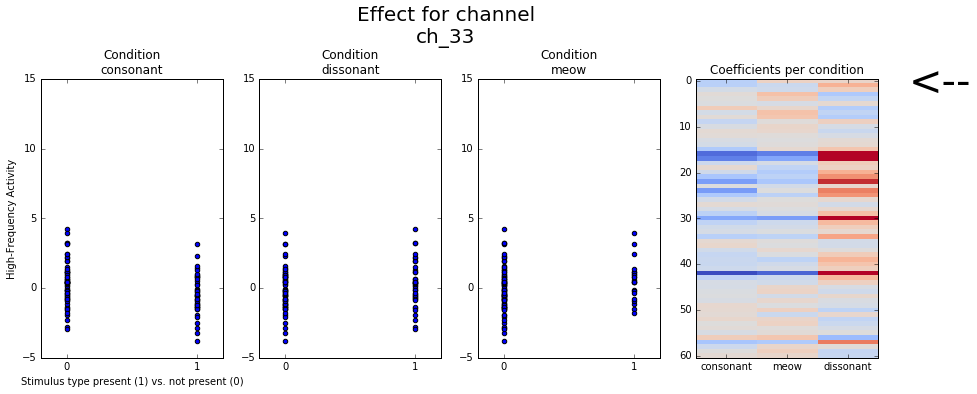

In [29]:
def plot_effect(ix_elec=0):
    fig, axs = plt.subplots(1, 4, figsize=(15, 5))
    for ii, ax in enumerate(axs[:3]):
        ax.scatter(X[:, ii], y[:, ix_elec])
        ax.set_title('Condition\n{}'.format(
                {val: key for key, val in epochs.event_id.items()}[ii + 1]))
        ax.set_xticks([0, 1])
    
    axs[3].imshow(mod.coef_, aspect='auto', interpolation='nearest',
               vmin=-2, vmax=2, cmap='coolwarm')
    axs[3].text(3, ix_elec + 3, '<--', color='k', fontsize=40)
    fig.suptitle('Effect for channel\n{}'.format(epochs.ch_names[ix_elec]),
                 y=1.1, fontsize=20)
    axs[3].set_title('Coefficients per condition')
    axs[3].set_xticks([0, 1, 2])
    axs[3].set_xticklabels(epochs.event_id.keys())
    axs[0].set_ylabel('High-Frequency Activity')
    _ = plt.setp(axs[:3], ylim=[-5, 15])
    axs[0].set_xlabel('Stimulus type present (1) vs. not present (0)')

_ = interact(plot_effect,
             ix_elec=IntSlider(min=0, max=y.shape[-1],
                               step=1, continuous_update=False))
